## Execute PID Control

### Setup and Connect

In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False
ble = get_ble_controller()
ble.connect()

2022-03-21 21:26:00,788 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:07:21:8D:B3:44


Exception: Could not find device with address: C0:07:21:8D:B3:44 and service uuid: 9a48ecba-2e92-082f-c079-9e75aae428b1

### Define Robot Controller Class

In [ ]:
class RobotControl():
    # Initialize Function
    def __init__(self, ble):
        self.ble = ble
        self.notifiers_on = False
        self.TOF_HISTORY_LEN = 60
        self.IMU_HISTORY_LEN = 300

        # A variable to store the latest sensor value
        self.latest_tof_front_reading = None
        
        # A list to store the history of all the sensor values
        # Each item in the list is a tuple (value, time)
        # WARNING: The list could grow really fast; you need to deal with this accordingly.
        self.tof1_readings = [] # TODO change these to a bounded queue
        self.tof2_readings = []
        self.imu_readings = []
        self.bot_pid_debug = []
        
        # A variable to store the latest imu reading
        self.latest_imu_reading = None
        
        # Activate notifications (if required)
        self.setup_notify()
    
    # A function to activate various notifications (if required)
    def setup_notify(self):
        # Code to setup various notify events
        # Ex:
        ble.start_notify(ble.uuid['RX_TOF1'], self.tof1_callback_handler)
        ble.start_notify(ble.uuid['RX_TOF2'], self.tof2_callback_handler)
        ble.start_notify(ble.uuid['RX_IMU'], self.imu_callback_handler)
        ble.start_notify(ble.uuid['RX_MOTOR_PID'], self.motor_pid_callback_handler)
        self.notifiers_on = True

    def stop_notify(self):
        ble.stop_notify(ble.uuid['RX_TOF1'])
        ble.stop_notify(ble.uuid['RX_TOF2'])
        ble.stop_notify(ble.uuid['RX_IMU'])
        ble.stop_notify(ble.uuid['RX_MOTOR_PID'])
        self.notifiers_on = False
    
    def tof1_callback_handler(self, uuid, byte_array):
        self.tof1_readings.append( self.ble.bytearray_to_float(byte_array) )

    def tof2_callback_handler(self, uuid, byte_array):
        self.tof2_readings.append( ( self.ble.bytearray_to_float(byte_array), time.time() ) )
    
    def imu_callback_handler(self, uuid, byte_array):
        self.imu_readings.append( (self.ble.bytearray_to_string(byte_array), time.time()) )

    def motor_pid_callback_handler(self, uuid, byte_array):
        self.bot_pid_debug.append( self.ble.bytearray_to_float(byte_array) )

    # An example function to fetch the front TOF sensor reading
    # Here we assume RX_TOF1 is a valid UUID defined in connection.yaml and
    # in the Arduino code as well
    def get_front_tof(self):
        ble.send_command(CMD.GET_FRONT_TOF, None)
        return self.tof1_readings[-1]

    
    # An example function to fetch the IMU readings as a string
    # Here we assume RX_IMU is a valid UUID defined in connection.yaml and
    # in the Arduino code as wellt
    # def get_imu(self):
    #     self.latest_imu_reading = self.ble.receive_string(self.ble.uuid['RX_IMU'])
    #     pass
    
    def start_pid(self, setpoint):
        ble.send_command(CMD.START_PID, setpoint)

    def stop_pid(self):
        ble.send_command(CMD.STOP_PID, None)

    # A function to instruct the robot to move forward
    def move_forward(self, speed):
        ble.send_command(CMD.MOVE_FORWARD, speed)
    
    def set_motor_calibration(self, new_val):
        ble.send_command(CMD.SET_MOTOR_CALIB, new_val)
    
    # A function to stop robot motion
    def stop(self):
        ble.send_command(CMD.STOP, None)

    def start_data_collection(self):
        ble.send_command(CMD.START_DATA_COLLECTION, None)
    
    def stop_data_collection(self):
        temp_notif = self.notifiers_on
        if not temp_notif:
            self.setup_notify()
        ble.send_command(CMD.STOP_DATA_COLLECTION, None)
        for i in range(self.TOF_HISTORY_LEN):
            ble.send_command(CMD.GET_TOF1_DATA, i)
            ble.send_command(CMD.GET_PID_DATA, i)
        if not temp_notif:
            self.stop_notify()

    """
    Step response, but hard break at step_stop
    """
    def start_step_response(self, step_stop):
        ble.send_command(CMD.START_STEP_RESPONSE, step_stop)
    
    def stop_step_response(self):
        ble.send_command(CMD.STOP_STEP_RESPONSE, None)



### Run PID

In [ ]:
bot = RobotControl(ble)
bot.stop_notify()
bot.set_motor_calibration(1.8)
bot.start_data_collection()
bot.start_step_response(400)
# bot.start_pid(0.035) # OLD: 0.05
time.sleep(2.5)
bot.stop_step_response()
bot.stop()
bot.stop_data_collection()


print(f"motor_raw = {bot.bot_pid_debug}")
print(f"tof_raw = {bot.tof1_readings}")

motor_raw = [0.0, 32583.0, 141.0, 32678.0, 141.0, 32777.0, 141.0, 32886.0, 141.0, 32999.0, 141.0, 33098.0, 141.0, 33198.0, 141.0, 33305.0, 141.0, 33400.0, 141.0, 33505.0, 141.0, 33609.0, 141.0, 33714.0, 141.0, 33817.0, 141.0, 33922.0, 141.0, 34024.0, 141.0, 34130.0, 141.0, 34233.0, 141.0, 34339.0, 0.0, 34435.0, 0.0, 34541.0, 141.0, 34639.0, 141.0, 34736.0, 141.0, 34800.0, 141.0, 34867.0, 141.0, 34974.0, 141.0, 35071.0, 141.0, 35179.0, 141.0, 35282.0, 141.0, 35388.0, 141.0, 35501.0, 141.0, 35599.0, 141.0, 35708.0, 141.0, 35803.0, 0.0, 35915.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tof_raw = [353.0, 32583.0, 3682.0, 32678.0, 4079.0, 32777.0, 3875.0, 32886.0, 3847.0, 32999.0, 3678.0, 33098.0, 810.0, 33198.0, 3349.0, 33305.0, 2761.0, 33400.0, 2799.0, 33505.0, 2587.0, 3360

### Visualize

In [ ]:
tof_times = []
tof_vals = []
pid_vals = []
pid_times = []

last_data_point = 0
for i in reversed(range(len(bot.tof1_readings))):
  if i % 2 == 0: continue
  if bot.tof1_readings[i] == 0: continue
  last_data_point = i
  break
print(last_data_point)
# Manual override in case of crash
# last_data_point = 99
for i,val in enumerate(bot.tof1_readings[:last_data_point+1]):
  if i % 2 == 0:
    tof_vals.append(val) # Even index, so this is a distance
  else:
    tof_times.append(val)

for i,val in enumerate(bot.bot_pid_debug[:last_data_point+1]):
  if i % 2 == 0:
    pid_vals.append(val) # Even index, so this is a distance
  else:
    pid_times.append(val)

tof_times = [(x - tof_times[0]) / 1000 for x in tof_times]
tof_vals = [x / 1000 for x in tof_vals]
pid_times = [(x - pid_times[0]) / 1000 for x in pid_times]
print(f"{len(tof_times)} data points")

67
34 data points


### Time of Flight Reading vs Time

Text(0.5, 1.0, 'ToF Distance vs Time')

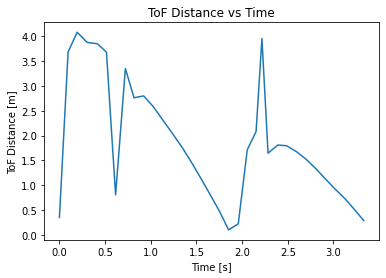

In [ ]:
plt.plot(tof_times, tof_vals)
plt.xlabel("Time [s]")
plt.ylabel("ToF Distance [m]")
plt.title("ToF Distance vs Time")

### Velocity vs Time

Max Velocity: 34.402985074627004


(0.0, 5.0)

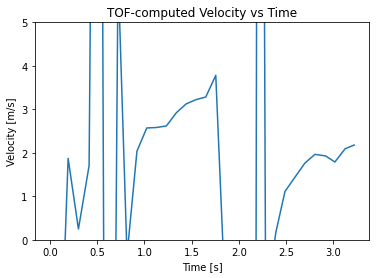

In [ ]:
# Positive velocity means towards the wall
tof_dx = np.diff(tof_vals)
tof_dt = np.diff(tof_times)
tof_vel = tof_dx / tof_dt
print(f"Max Velocity: {-1 * min(tof_vel)}")
plt.plot(tof_times[:-1], -1 * tof_vel)
plt.title("TOF-computed Velocity vs Time")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.ylim(0,5)
# TODO filter this somehow, noisy values make the graph look bad but your ToF distance graph makes sense
# There's a steady state in here somewhere, just filter it! It should be between 1.25 and 1.50 m/s, roughly

### PID Input vs Time

Text(0.5, 1.0, 'PID input vs Time')

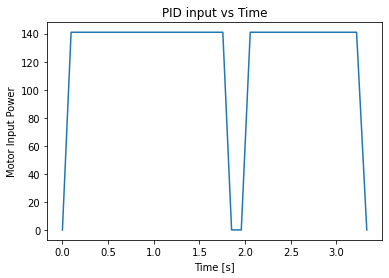

In [ ]:
plt.plot(pid_times, pid_vals)
plt.xlabel("Time [s]")
plt.ylabel("Motor Input Power")
plt.title("PID input vs Time")

## Run Kalman Filter

In [ ]:
# data
kf_tof = []
kf_times = []

# TODO fill in parameters
sigma_1 = 0.1
sigma_2 = 0.1
sigma_4 = 0.1 # Measurement noise
n = 1 # state space dimension
dt = None

Sigma_u = np.array([[sigma_1**2,0],[0,sigma_2**2]]) # We assume uncorrelated noise, therefore a diagonal matrix works.
Sigma_z = np.array([[sigma_4**2]])
C = np.array([[-1,0]]) # Measurement is -1 * (distance to wall)

x = np.array([[-1 * kf_tof[0]],[0]]) # TODO initial state

A = None # TODO compute A and B
B = None
Ad = np.eye(n) + dt * A 
Bd = dt * B

def kf(mu,sigma,u,y):
    
    mu_p = A.dot(mu) + B.dot(u) 
    sigma_p = A.dot(sigma.dot(A.transpose())) + Sigma_u
    
    y_m = y-C.dot(mu_p)
    sigma_m = C.dot(sigma_p.dot(C.transpose())) + Sigma_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))

    mu = mu_p + kkf_gain.dot(y_m)    
    sigma=(np.eye(3)-kkf_gain.dot(C)).dot(sigma_p)

    return mu,sigma



IndexError: list index out of range

2022-03-20 17:26:55,637 | INFO     |: Disconnected from 7AE0A3CC-63D5-13D9-39BA-D29A7DC67D14
